# Coronavirus: a post-vaccination landscape

## 1. Introduction

Exploratory data analysis for the INM430 Principles of Data Science assessment. 

## 2. Exploratory data analysis

### 2.1 Initial data inspection

Let's load some core modules:

In [1]:
#import core packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

print("Packages loaded!")

Packages loaded!


Let's check data types and descriptive statistics:

In [2]:
#read csv
odf = pd.read_csv(r"C:\Users\josep\Desktop\data_science_MSc\Term 1\INM430 Principles of Data Science\project\workdir\MSOA\MSOA_final.csv")

#remove AreaNames
df = odf.drop(columns = 'AreaName')

#make MSOA code to be index
df.index = df.Code
df = df.drop(columns = 'Code') #remove old Code column
 
#view df
df.describe()

,Population_mid2020,propCas,propVac,prop0_15,prop16_24,prop25_64,prop65+,PopDens,IMD_score,LifeExpMale,LifeExpFemale,percAge15Smoking2014,percBAME_2011,percOvercrowded_2011,percDeb_2011
count,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6733.000000,6770.000000,6788.000000,6789.000000,6789.000000,6789.000000
mean,8327.732214,0.020908,0.690863,0.190988,0.101039,0.516378,0.191588,3554.773354,21.588275,79.646829,83.503545,5.565468,13.661349,8.459361,17.790558
std,2047.418635,0.006582,0.090283,0.039448,0.053834,0.046737,0.070696,3838.274286,13.210124,2.987895,2.785225,2.378205,18.001718,8.237806,4.334291
min,4843.000000,0.002700,0.287600,0.015000,0.040000,0.144000,0.004000,5.700000,2.200000,64.700000,73.600000,0.800000,0.400000,0.600000,3.600000
25%,6840.000000,0.016400,0.634500,0.167000,0.081000,0.491000,0.138000,762.600000,11.500000,77.700000,81.700000,3.900000,2.400000,3.200000,14.700000
50%,7999.000000,0.020300,0.707200,0.189000,0.090000,0.514000,0.191000,2671.800000,18.200000,79.900000,83.700000,5.300000,5.300000,5.400000,17.500000
75%,9383.000000,0.024800,0.757900,0.214000,0.102000,0.538000,0.240000,4724.200000,28.700000,81.800000,85.300000,6.800000,17.000000,9.900000,20.600000
max,27911.000000,0.064800,1.289700,0.393000,0.803000,0.743000,0.537000,28666.500000,86.900000,95.400000,98.400000,17.900000,94.400000,60.900000,38.900000


The descriptive statistics show that all variables appear to be of a continuous nature and varied in scale. Row counts also show that 'LifeExpMale', 'LifeExpFemale' and 'percAge15Smoking2014' are missing a small proportion of values.

We can see that some columns showing proportions have values > 1. This may be due to data being taken from different times period. For example, propVac which is calculated by dividing the cumulative total of double vaccinated individuals by the regional population estimate uses vaccination figures from late 2021 and population estimates from mid 2020. Therefore current population figures may be different from those captured a year ago causing the discrepancy. Moreover, MSOA regions can be small and causing variance to have an exaggerated impact on  the descriptive statistics of smaller populations.

Let's compress any values containing proportions > 1 to 1:

In [5]:
def col_compressor(col):
    "give column values a ceiling of 1 and a floor of 0"
    
    #create target list
    mylist = []
    
    #iterate through column values and
    for val in col:
        if val > 1:
            mylist.append(1)
        elif val < 0:
            mylist.append(0)
        else:
            mylist.append(val)
    #return list
    return mylist

#get a list of columns with proportions to compress
cols2comp = []
for col in df.columns.tolist():
    if 'prop' in col:
        cols2comp .append(col)
        
#compress columns
df[cols2comp] = df[cols2comp].apply(col_compressor)

### 2.2 Data visualisation: scaled data

We will look at data distributions and correlations to understand variable properties and interactions. Before we investigate our data, we need to scale values and impute missing data. We will use Sklearns MinMaxScaler to scale data, then impute values using miceforest. Let's scale variables and impute missing values before visualisation to they can the compared easily:

In [6]:
#import packages
import miceforest as mf
from sklearn.preprocessing import MinMaxScaler

#create scaler
scaler = MinMaxScaler(feature_range=(0, 100))

#fit scaler
scaled_data = scaler.fit_transform(df)

#replace data with scaled data
sc_df = pd.DataFrame(scaled_data, columns = df.columns, index = df.index)

#instantiate miceforest kernal
kds = mf.ImputationKernel(
  sc_df,
  save_all_iterations=True,
  random_state=1991
)

#run model 5 times
kds.mice(iterations=5)

#impute data
sc_df = kds.impute_new_data(sc_df)
sc_df = sc_df.complete_data(0)

#create X and y variables
sc_y = sc_df.propCas.values
sc_X = sc_df.drop(columns = ['propCas'])

#view descriptive statistics
sc_df.describe()

,Population_mid2020,propCas,propVac,prop0_15,prop16_24,prop25_64,prop65+,PopDens,IMD_score,LifeExpMale,LifeExpFemale,percAge15Smoking2014,percBAME_2011,percOvercrowded_2011,percDeb_2011
count,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000
mean,15.106347,29.320495,56.594688,46.557768,7.999854,62.166556,35.194776,12.383023,22.890526,48.663123,39.934085,27.866027,14.107818,13.033766,40.199882
std,8.875579,10.599737,12.621176,10.436045,7.055600,7.802483,13.263732,13.392070,15.596368,9.744358,11.245743,13.907797,19.150764,13.661369,12.278444
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.657014,22.061192,48.694554,40.211640,5.373526,57.929883,25.140713,2.640889,10.979929,42.345277,32.661290,18.128655,2.127660,4.311774,31.444759
50%,13.681290,28.341385,58.899495,46.031746,6.553080,61.769616,35.084428,9.302253,18.890201,49.511401,40.725806,26.315789,5.212766,7.960199,39.376771
75%,19.680943,35.587762,66.016283,52.645503,8.125819,65.776294,44.277674,16.463253,31.286895,55.374593,47.177419,35.087719,17.659574,15.422886,48.158640
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


**Overall distribution**

Let's look a the distributions of variables in the dataset:

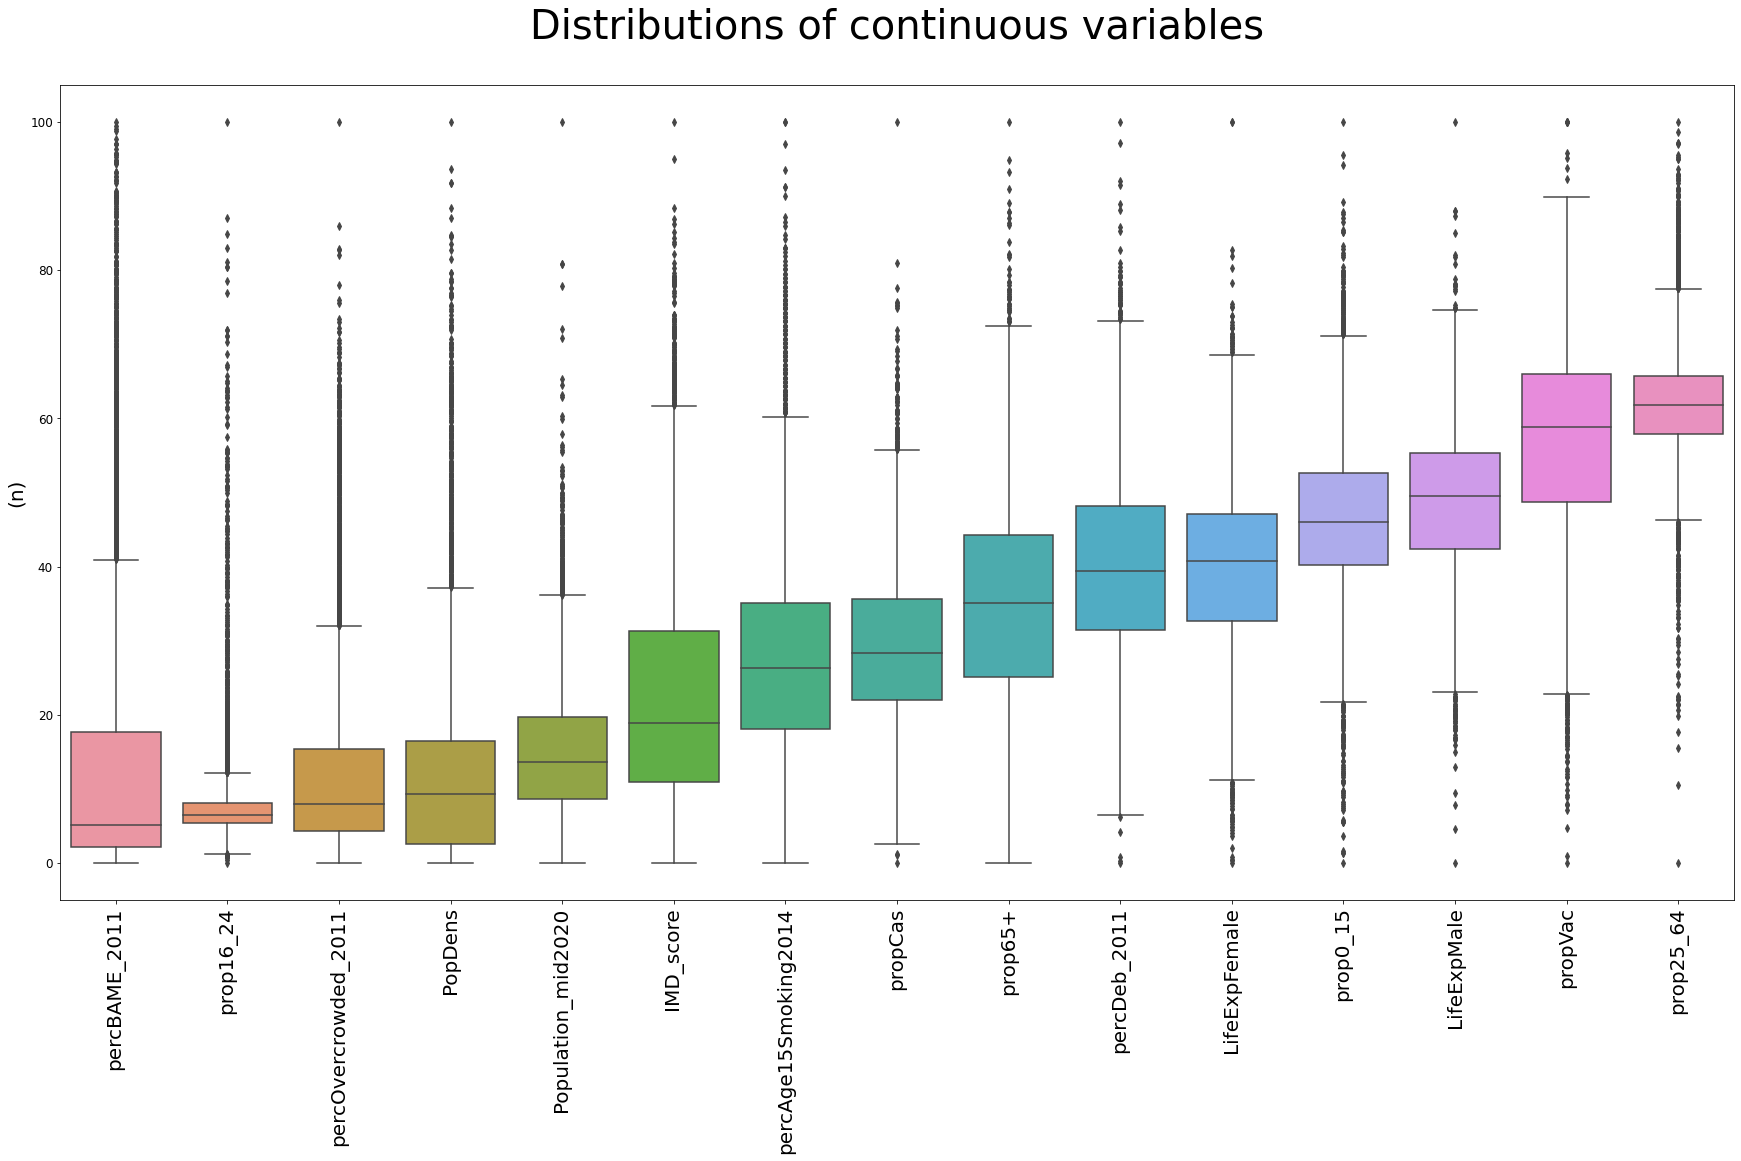

In [7]:
#create boxplot
plt.figure(figsize=(30,15))
sns.boxplot(data = sc_df[sc_df.median().sort_values().index.tolist()])
plt.xticks(fontsize=20, rotation = 90)
plt.yticks(fontsize=12)
plt.ylabel("(n)", fontsize = 20)
plt.title('Distributions of continuous variables', fontsize = 40, y = 1.05, x = 0.5)

#show plot
plt.show()

The boxplot shows that variable distributions vary from gamma distribution such as `percBAME_2011`, to near-normal distribution such as `LifeExpMale`. The dependent variable `propCas` shows a right skew.

**Correlation**

Now let's look for multicollinearity using Pearson correlation score:

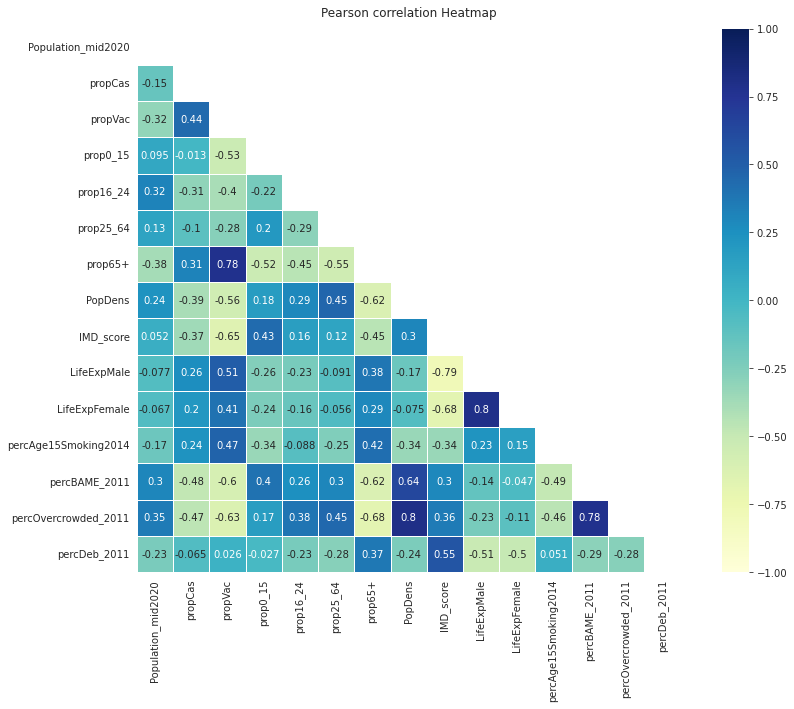

In [8]:
#create mask
corr = sc_df.corr(method = 'pearson').values
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

#create heatmap of pearson values
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax =  sns.heatmap(sc_df.corr(method = 'pearson'), vmin=-1, vmax=1, annot=True, linewidths=.5, mask = mask, square = True, cmap="YlGnBu")
    ax.set_title('Pearson correlation Heatmap', fontdict={'fontsize':12}, pad=12)


Let's visualise scatterlplots between the dependent variable `propCas` and each independent variable:

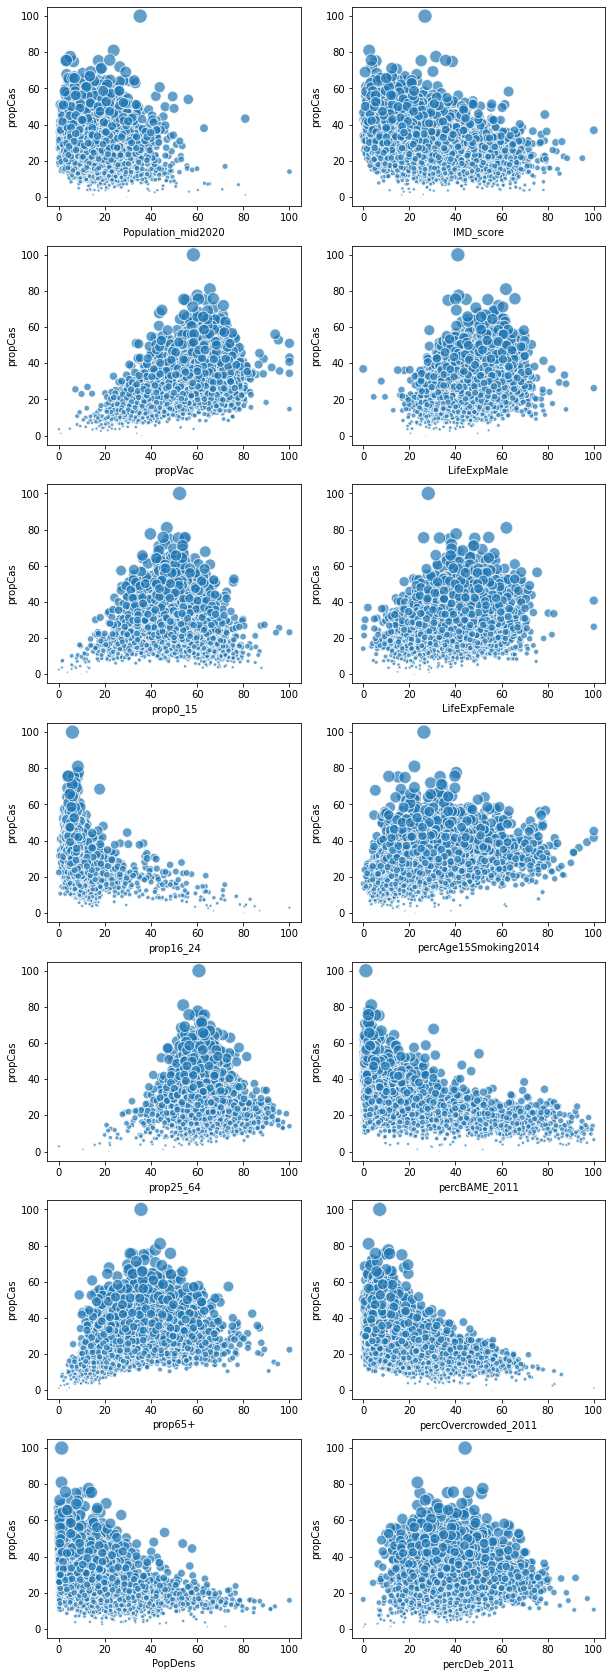

In [9]:
#extract independent variables
x_cols = sc_X.columns.tolist()

#craete subplot with independent variable against dependent variable
fig, axes = plt.subplots(7, 2, figsize=(10, 30))
sns.scatterplot(ax = axes[0,0],data=sc_df, y="propCas", x=x_cols[0], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[1,0],data=sc_df, y="propCas", x=x_cols[1], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[2,0],data=sc_df, y="propCas", x=x_cols[2], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[3,0],data=sc_df, y="propCas", x=x_cols[3], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[4,0],data=sc_df, y="propCas", x=x_cols[4], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[5,0],data=sc_df, y="propCas", x=x_cols[5], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[6,0],data=sc_df, y="propCas", x=x_cols[6], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[0,1],data=sc_df, y="propCas", x=x_cols[7], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[1,1],data=sc_df, y="propCas", x=x_cols[8], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[2,1],data=sc_df, y="propCas", x=x_cols[9], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[3,1],data=sc_df, y="propCas", x=x_cols[10], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[4,1],data=sc_df, y="propCas", x=x_cols[11], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[5,1],data=sc_df, y="propCas", x=x_cols[12], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)
sns.scatterplot(ax = axes[6,1],data=sc_df, y="propCas", x=x_cols[13], size="propCas", legend=False, sizes=(2, 200), alpha=0.7, edgecolors="black", linewidth=1)

plt.show()

**Distribution of dependent variable**

Now let's look at the depdendent variable `propCas` in isolation:

In [10]:
from scipy.stats import iqr
print("Median for propCas: ", np.median(sc_y))
print("Interquartile range for propCas: ", iqr(sc_y))

Median for propCas:  28.34138486312399
Interquartile range for propCas:  13.526570048309175


We can see that propcas has relatively small median and IQR showing results are compacted torwards low values. Let's count the outliers:

In [11]:
import numpy as np
import pandas as pd
outliers=[]
def detect_outlier(data_1):
    #ref https://medium.datadriveninvestor.com/finding-outliers-in-dataset-using-python-efc3fce6ce32
    
    threshold=2.5
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

outliers = detect_outlier(sc_y)
len(outliers)

107

There are 107 'outliers' in our dependent variable. Let's visualise the distribution in a boxplot:

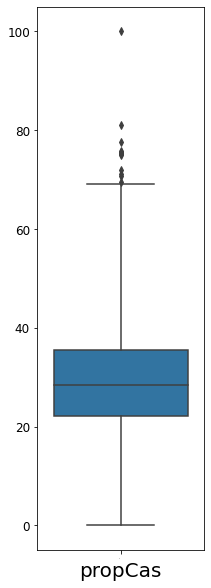

In [12]:
#create boxplot
plt.figure(figsize=(3,10))
sns.boxplot(data = sc_y, whis = 2.5)
plt.xticks(fontsize=0, rotation = 90)
plt.yticks(fontsize=12)
plt.ylabel("", fontsize = 20)
plt.xlabel("propCas", fontsize = 20)
#plt.title('propCas boxplot', fontsize = 15, y = 1.05, x = 0.5)

#show plot
plt.show()

Now let's assess the spread, kurtosis and skew in a histogram plot:

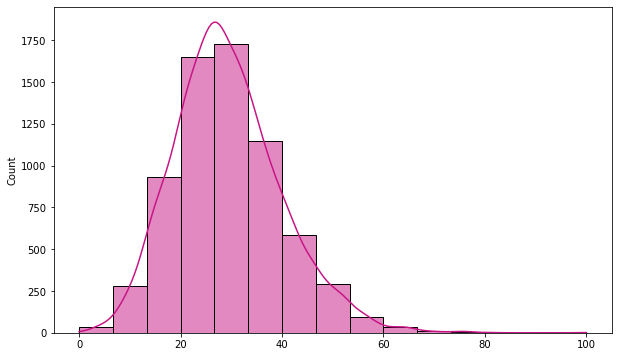

In [13]:
#import packages
from scipy.stats import kurtosis as kurt

#format chart area
plt.figure(figsize=(10, 6))

#plot the dependent variable
yhist = sns.histplot(x = sc_y, bins = 15,  color="mediumvioletred", kde = True)
#plt.text(70, 1000, "Kurtosis: "+str(round(kurt(sc_y),2)), horizontalalignment='left', size='medium', color='k', weight='semibold')
#yhist.set_title('propCas histogram')
#yhist.set_xlabel('propCas')

#show plot
plt.show()

We can see that `propCas` has a right-skew distribution, with moderate spread and kurtosis.

### 2.3 Data visualisation: standardized data

We are going to be using generalised linear models, which perform better with normally distributed data. Let's standardize and scale the data:

In [14]:
#import packages
import miceforest as mf
from sklearn.preprocessing import StandardScaler

#Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
st_df = pd.DataFrame(scaled_data, columns = df.columns, index = df.index)

#instantiate miceforest kernal
kds = mf.ImputationKernel(
  st_df,
  save_all_iterations=True,
  random_state=1991
)

#run model 5 times
kds.mice(iterations=5)

#impute data
st_df = kds.impute_new_data(st_df)
st_df = st_df.complete_data(0)

#create X and y variables
st_y = st_df.propCas.values
st_X = st_df.drop(columns = ['propCas'])

#view descriptive statistics
st_df.describe()

,Population_mid2020,propCas,propVac,prop0_15,prop16_24,prop25_64,prop65+,PopDens,IMD_score,LifeExpMale,LifeExpFemale,percAge15Smoking2014,percBAME_2011,percOvercrowded_2011,percDeb_2011
count,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6789.000000,6789.000000,6789.000000,6.789000e+03,6.789000e+03,6.789000e+03
mean,4.713787e-16,-9.430273e-16,1.442423e-15,7.933949e-16,2.878174e-17,2.356832e-16,-8.281292e-16,2.417666e-16,-7.211298e-16,-0.002658,-0.000056,-0.000153,-1.785776e-16,9.171564e-16,2.642033e-16
std,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.001568,1.000847,1.000079,1.000074e+00,1.000074e+00,1.000074e+00
min,-1.702138e+00,-2.766357e+00,-4.484436e+00,-4.461575e+00,-1.133914e+00,-7.968122e+00,-2.653655e+00,-9.247215e-01,-1.467791e+00,-5.002833,-3.556006,-2.003957,-7.367256e-01,-9.541303e-01,-3.274262e+00
25%,-7.266915e-01,-6.849074e-01,-6.259889e-01,-6.081418e-01,-3.722606e-01,-5.430303e-01,-7.580675e-01,-7.275090e-01,-7.637338e-01,-0.651620,-0.647588,-0.700357,-6.256169e-01,-6.384890e-01,-7.131007e-01
50%,-1.605712e-01,-9.237802e-02,1.826277e-01,-5.040807e-02,-2.050684e-01,-5.087728e-02,-8.320176e-03,-2.300613e-01,-2.565097e-01,0.084739,0.070540,-0.111634,-4.645093e-01,-3.714079e-01,-6.704203e-02
75%,5.154517e-01,5.913097e-01,7.465460e-01,5.833803e-01,1.785452e-02,4.626737e-01,6.848424e-01,3.046976e-01,5.383938e-01,0.687214,0.645042,0.519141,1.854766e-01,1.748943e-01,6.482372e-01
max,9.565562e+00,6.668534e+00,3.439339e+00,5.121305e+00,1.304027e+01,4.849255e+00,4.886256e+00,6.542934e+00,4.944430e+00,5.272722,5.348781,5.186871,4.485383e+00,6.366319e+00,4.870692e+00


**Overall distribution**

Let's look a the distributions of variables in the dataset:

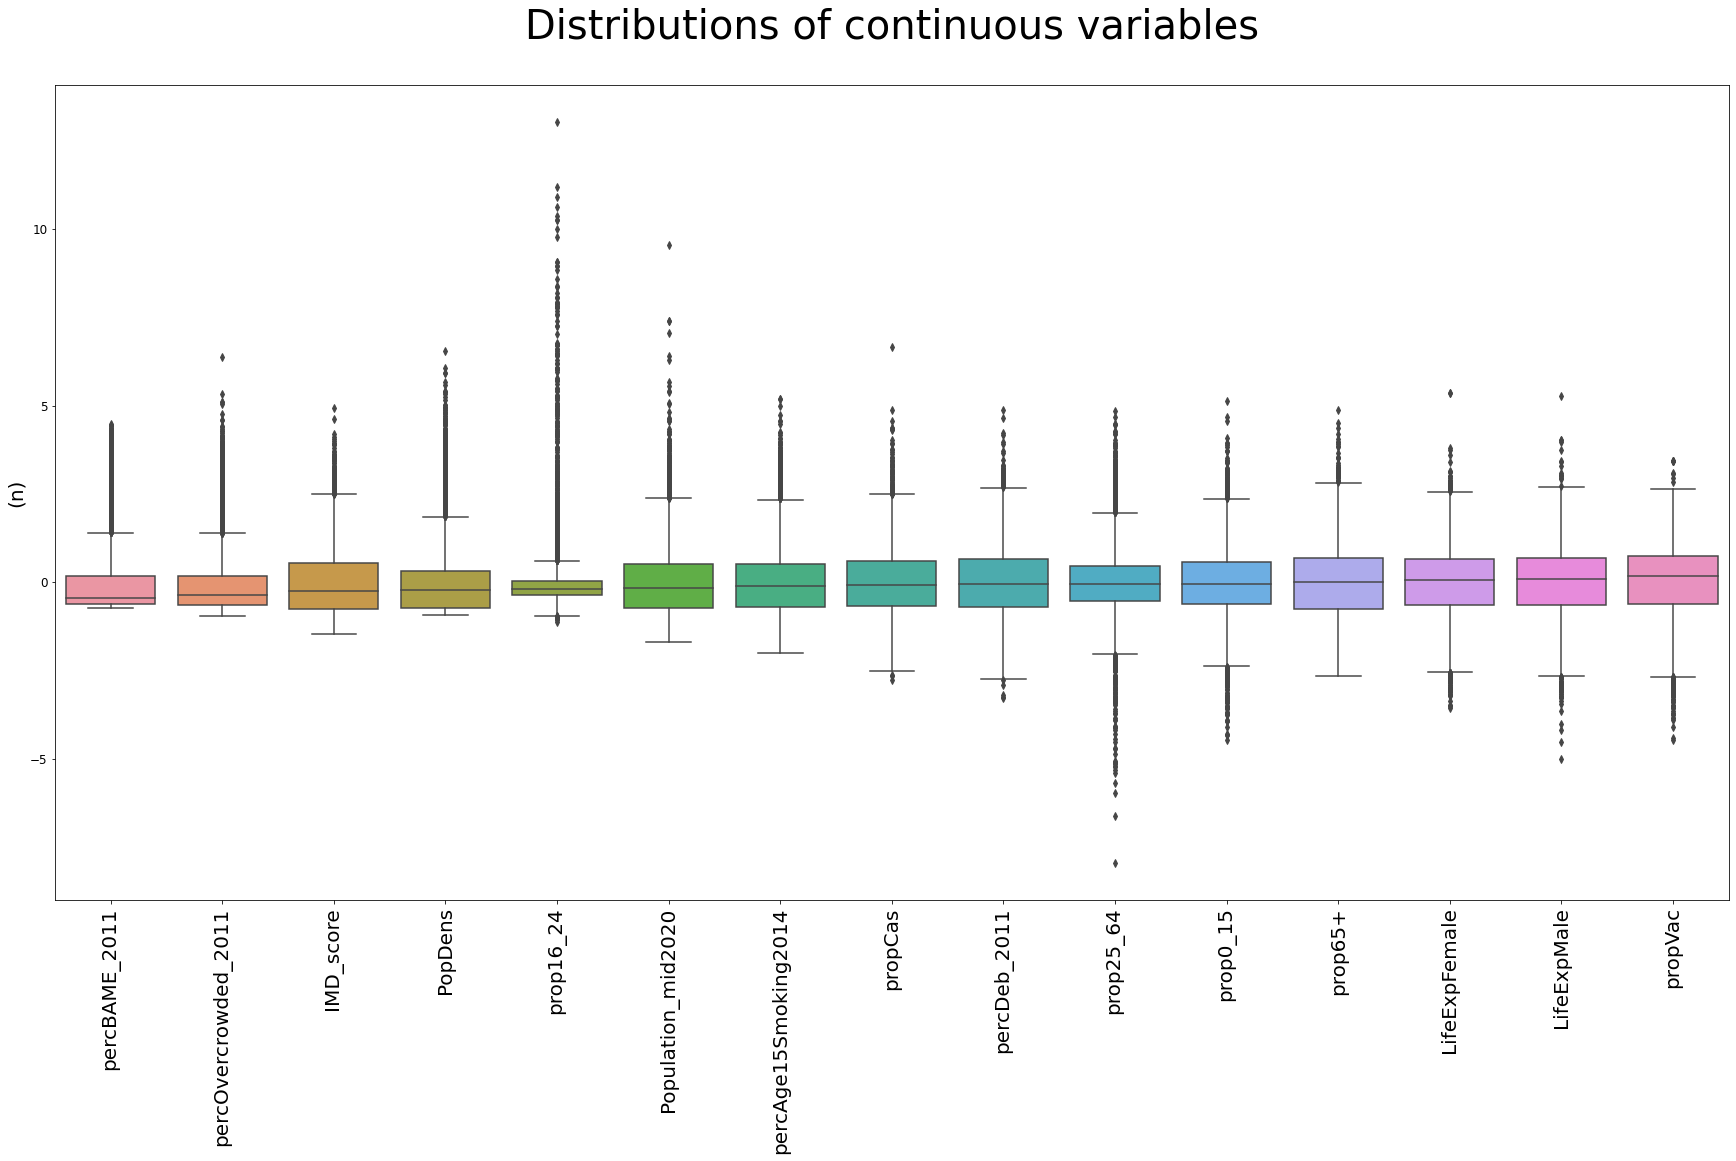

In [15]:
#create boxplot
plt.figure(figsize=(30,15))
sns.boxplot(data = st_df[st_df.median().sort_values().index.tolist()])
plt.xticks(fontsize=20, rotation = 90)
plt.yticks(fontsize=12)
plt.ylabel("(n)", fontsize = 20)
plt.title('Distributions of continuous variables', fontsize = 40, y = 1.05, x = 0.5)

#show plot
plt.show()

We can see that the data has been centered around 0 with appromixately 0 standard devation. Standard devation isn't exacltly 0 due to the handling of complex numbers.

### 2.4 Data visualisation:  normalized data

In [16]:
#import packages
import miceforest as mf
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer(method='box-cox', standardize=True)

#Standardize data
transformed_data = transformer.fit_transform(df)
tr_df = pd.DataFrame(transformed_data, columns = df.columns, index = df.index)

#instantiate miceforest kernal
kds = mf.ImputationKernel(
  tr_df,
  save_all_iterations=True,
  random_state=1991
)

#run model 5 times
kds.mice(iterations=5)

#impute data
tr_df = kds.impute_new_data(tr_df)
tr_df = tr_df.complete_data(0)

#create X and y variables
tr_y = tr_df.propCas.values
tr_X = tr_df.drop(columns = ['propCas'])

#view descriptive statistics
tr_df.describe()

,Population_mid2020,propCas,propVac,prop0_15,prop16_24,prop25_64,prop65+,PopDens,IMD_score,LifeExpMale,LifeExpFemale,percAge15Smoking2014,percBAME_2011,percOvercrowded_2011,percDeb_2011
count,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6.789000e+03,6789.000000,6789.000000,6789.000000,6.789000e+03,6.789000e+03,6.789000e+03
mean,2.745841e-13,2.860840e-15,1.924452e-16,-1.079969e-15,5.457411e-16,-3.103588e-15,1.424304e-15,2.398533e-16,8.838775e-16,-0.001510,-0.000199,-0.000016,-2.233381e-15,-3.799484e-15,6.278345e-16
std,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.000074e+00,1.003244,1.001072,1.000001,1.000074e+00,1.000074e+00,1.000074e+00
min,-2.714142e+00,-4.036372e+00,-2.819791e+00,-4.583988e+00,-7.563365e+00,-7.468770e+00,-3.492898e+00,-2.287719e+00,-2.979135e+00,-3.991074,-3.345953,-3.163981,-2.891149e+00,-3.412177e+00,-4.105379e+00
25%,-7.238825e-01,-6.433097e-01,-7.311785e-01,-6.052684e-01,-5.330128e-01,-5.478090e-01,-7.264292e-01,-7.186686e-01,-7.289376e-01,-0.686290,-0.659625,-0.645615,-8.175097e-01,-7.122672e-01,-6.884055e-01
50%,2.470571e-02,-1.054919e-02,8.099054e-02,-4.652863e-02,3.733416e-04,-5.700206e-02,4.884400e-02,1.502407e-01,-1.484204e-02,0.037123,0.052073,0.025005,-7.974961e-02,-2.803858e-02,-1.968436e-02
75%,7.041024e-01,6.455391e-01,7.399329e-01,5.855523e-01,5.305303e-01,4.582778e-01,7.099625e-01,6.549852e-01,7.364969e-01,0.668713,0.635314,0.625467,8.436619e-01,6.850126e-01,6.743941e-01
max,3.711700e+00,4.844763e+00,5.063751e+00,5.046874e+00,2.904299e+00,4.974644e+00,4.105996e+00,2.883025e+00,2.758342e+00,6.788722,5.878251,3.524038,1.915164e+00,2.395073e+00,4.156232e+00


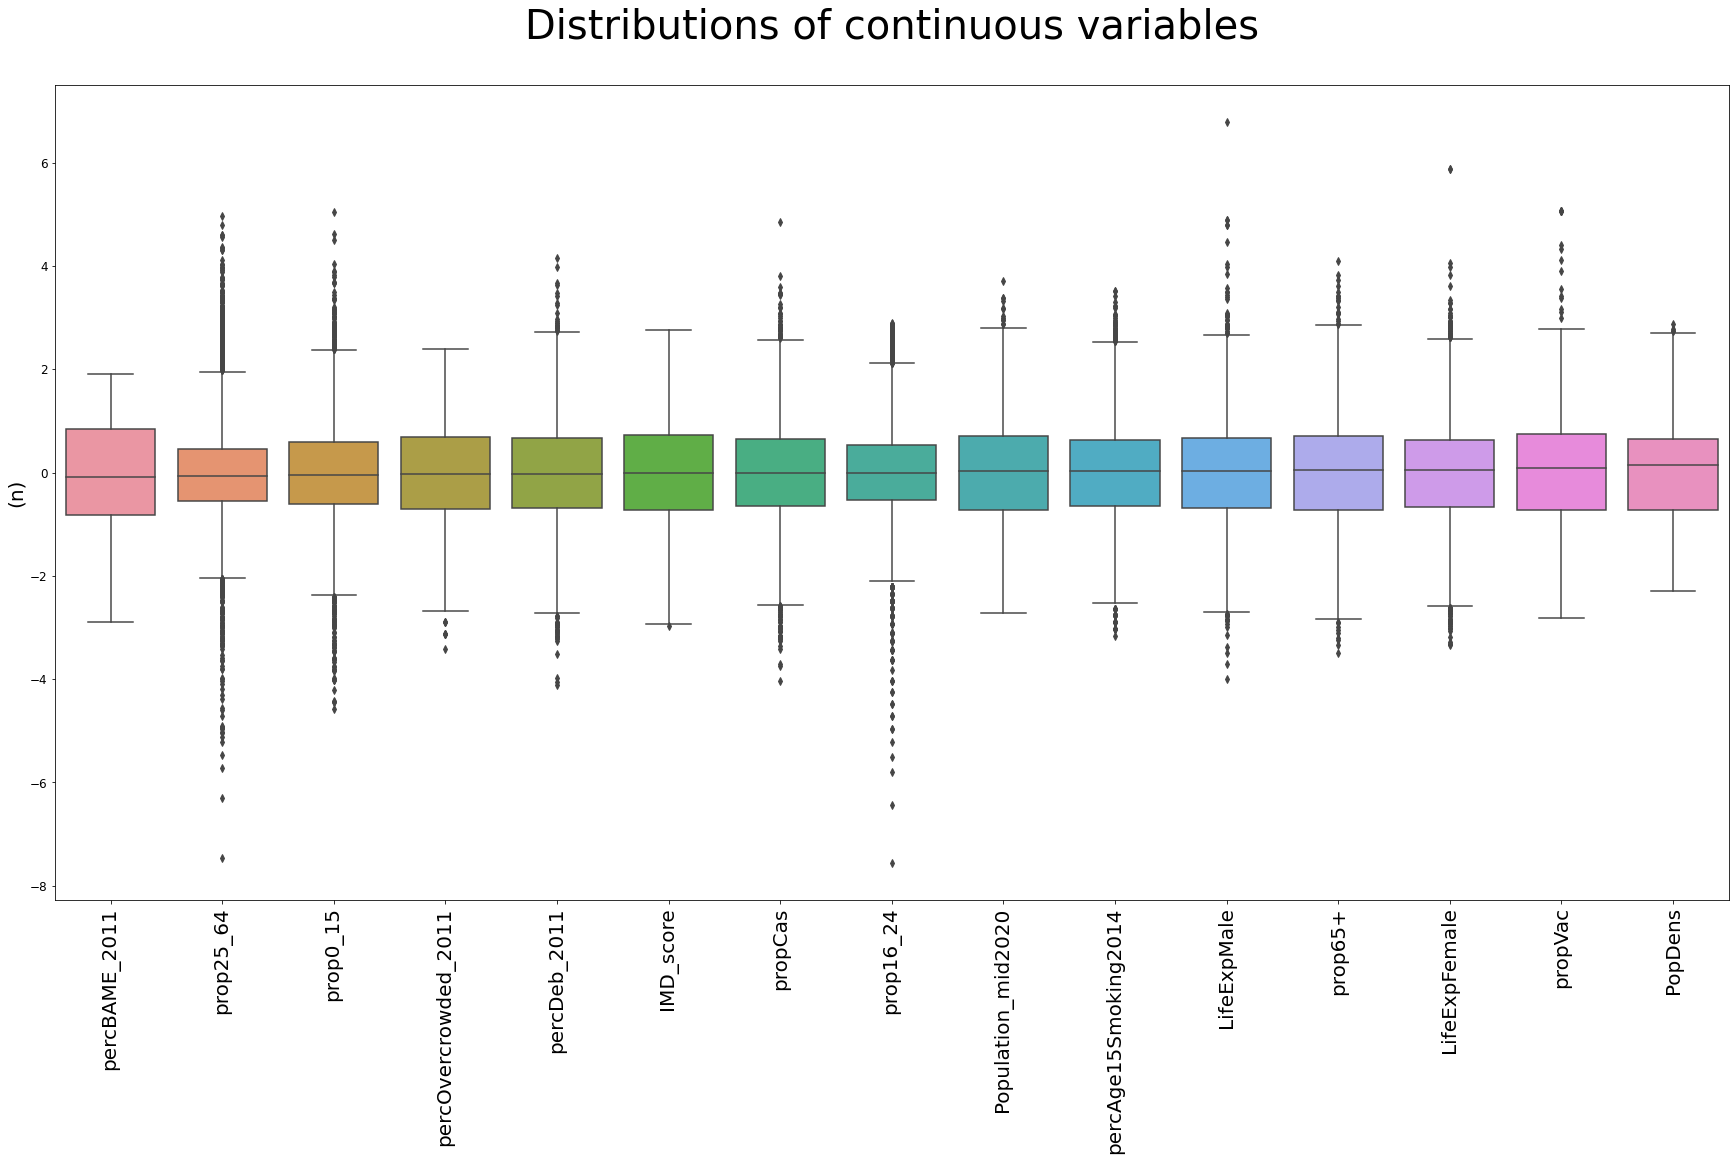

In [17]:
#create boxplot
plt.figure(figsize=(30,15))
sns.boxplot(data = tr_df[tr_df.median().sort_values().index.tolist()])
plt.xticks(fontsize=20, rotation = 90)
plt.yticks(fontsize=12)
plt.ylabel("(n)", fontsize = 20)
plt.title('Distributions of continuous variables', fontsize = 40, y = 1.05, x = 0.5)

#show plot
plt.show()

We can see that the data has been standardized and normalized with data appearing more normally distributed and with ~0 standard deviation.

## 3. Modelling

### 3.1 Creating test-train datasets

Let's train regression and ensemble models on our scaled, standardized and normalized datasets. First let's create test-train datasets:

In [68]:
#import package
from sklearn.model_selection import train_test_split

#create 1:5 test train split
sc_X_train, sc_X_test, sc_y_train, sc_y_test = train_test_split(sc_X, sc_y, test_size=0.2, random_state=42)
st_X_train, st_X_test, st_y_train, st_y_test = train_test_split(st_X, st_y, test_size=0.2, random_state=42)
tr_X_train, tr_X_test, tr_y_train, tr_y_test = train_test_split(tr_X, tr_y, test_size=0.2, random_state=42)

### 3.2 Evalutation functions

Let's create a function to return optimized models for training data:

In [110]:
def Modeller(X_train,y_train, method, scoring_met):
    """function that finds optimized models for linear models (ridge, lasso & elastic net) and one ensemble method (Random Forest)"""
    import math
    import numpy as np
    from sklearn import metrics
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import GridSearchCV
    
    
    #Regression
    if method == 'regression':
        print("Regression selected...")
        from sklearn.model_selection import RepeatedKFold
        alg_name = None
        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        
        #Ridge
        print("\nPerforming Ridge GridSearch...")
        from sklearn.linear_model import Ridge
        rr = Ridge()
        
        #create grid
        param_grid = dict()
        param_grid['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
        param_grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
        param_grid['fit_intercept'] = [True, False]
              
        
        #run gridsearch
        grid_search = GridSearchCV(estimator = rr, param_grid = param_grid, cv = cv, scoring = scoring_met, n_jobs = -1, verbose = 2)
        grid_search.fit(X_train, y_train)
        
        #print score
        print("Optimized grid best training", scoring_met, "score: ", grid_search.best_score_)
            
        #update scores
        best_score = grid_search.best_score_
        best_grid = grid_search.best_estimator_
        alg_name = 'Lasso'
                
        #Lasso
        print("\nPerforming Lasso GridSearch...")
        from sklearn.linear_model import Lasso
        lr = Lasso()
        
        #create grid
        param_grid = dict()
        param_grid['selection'] = ['cyclic', 'random']
        param_grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
        param_grid['warm_start'] = [True, False]
        param_grid['max_iter']= [10000]

        #run gridsearch
        grid_search = GridSearchCV(estimator = lr, param_grid = param_grid, cv = cv, scoring = scoring_met, n_jobs = -1, verbose = 2)
        grid_search.fit(X_train, y_train)
              
        #print score
        print("Optimized grid best training", scoring_met, "score: ", grid_search.best_score_)
        
        #update scores
        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_grid = grid_search.best_estimator_
            alg_name = 'Lasso'
        else:
            pass
            
                
        #ElasticNet
        print("\nPerforming ElasticNet GridSearch...")
        from sklearn.linear_model import ElasticNet
        er = ElasticNet()
        
        #create grid
        param_grid = dict()
        param_grid['selection'] = ['cyclic', 'random']
        param_grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
        param_grid['l1_ratio'] = np.linspace(0.1,1,10)
        param_grid['warm_start'] = [True, False]

        #run gridsearch
        grid_search = GridSearchCV(estimator = er, param_grid = param_grid, cv = cv, scoring = scoring_met, n_jobs = -1, verbose = 2)
        grid_search.fit(X_train, y_train)
        
                
        #print score
        print("Optimized grid best training", scoring_met, "score: ", grid_search.best_score_)
        
        #update scores
        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_grid = grid_search.best_estimator_
            alg_name = 'ElasticNet'
        else:
            pass
        
        #return best score
        print("\nOptimized grid:", alg_name,  "\nBest training", scoring_met,": ",best_score)
        
        return [best_grid, best_score]

    
    #Random Forest
    if method == 'ensemble':
        print("Ensemble selected...")
        from sklearn.ensemble import RandomForestRegressor
        rf = RandomForestRegressor()
        
        #Random Search
        
        print("\nRunning Random Search...")
        #specify variables
        train_size = X_train.shape[0]
        est_start = math.ceil(train_size)/100
        n_estimators = [int(x) for x in np.linspace(start = math.ceil(train_size)/100, stop = math.ceil(train_size)/100*50, num = 10)]
        max_features = ['auto', 'sqrt']
        max_depth = [int(x) for x in np.linspace(math.ceil(train_size)/100, math.ceil(train_size)/100*10, num = 10)]
        max_depth.append(None)
        min_samples_split = [2,4,6,8,10]
        min_samples_leaf = [2,4,6,8,10]
        bootstrap = [True, False]
        
        #create grid
        random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
        
        #fit grid
        rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 40, cv = 3,scoring = scoring_met, verbose=1, random_state=42, n_jobs = -1)
        rf_random.fit(X_train, y_train)
        best_model = rf_random.best_estimator_
        
        #show scores
        print("Random Search", scoring_met, "scores: ", rf_random.best_score_)
        
        #Optimized search
        print("\nRunning Optimized Search...")
        
        #extract Random Search Best params
        opt_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
        for k, v in best_model.get_params().items():
            if k in opt_grid.keys():
                opt_grid.update({k:v})
                opt_grid.items()
        
        #create array of parameters for gridsearch
        for k, v in opt_grid.items():
            if type(v) == int:
                if v in [2,3,4]:
                    opt_arr = [v, v+1, v+2,]
                elif v > 4 and v < 10:
                    opt_arr = [v-1, v, v+1]
                elif v > 10:
                    frag = math.ceil(v)/10
                    opt_arr = [v-frag,v,v+frag]
                    opt_arr = [round(x) for x in opt_arr]
                opt_grid.update({k:opt_arr})   
            else:
                pass
            opt_grid.update({'max_features': ['auto', 'sqrt']})
            opt_grid.update({'bootstrap': [True, False]})
        
        #run gridsearch
        grid_search = GridSearchCV(estimator = rf, param_grid = opt_grid, cv = 3, scoring = scoring_met, n_jobs = -1, verbose = 2)
        grid_search.fit(X_train, y_train)
        best_grid = grid_search.best_estimator_
        best_score = grid_search.best_score_
        
        print("\nOptimized grid best training", scoring_met, "score: ", grid_search.best_score_)
        
        return [best_grid, best_score]

Now let's create a function to evaluate test data:

In [20]:
def test_scores(mdl, X_train, y_train, X_test, y_test):
    """returns proportional prediction error (%) and r2 scores for model on a specified test dataset """
    
    #import packages
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    import numpy as np
    
    #fit model
    mdl.fit(X_train, y_train)
    
    #predict data
    y_pred = mdl.predict(X_test)

    #produce proportional error score
    score = -metrics.mean_absolute_error(y_test, y_pred)
    upp = float(max(y_test))
    low = float(min(y_test))
    ran = upp - low
    prop_score = score/ran
    
    #produce r2 score
    r2 = metrics.r2_score(y_test, y_pred)
        

    return [abs(prop_score)*100, r2]

### 3.3 Ensemble modelling

**Scaled data**

Training data:

In [239]:
[best_model, score] = Modeller(sc_X_train, sc_y_train, 'ensemble', 'neg_mean_absolute_error')

print("\nBest model paramters: ", best_model)
upp = float(max(sc_y_train))
low = float(min(sc_y_train))
ran = upp - low
prop_score = score/ran
print("\nProportional MAE (%): ", abs(prop_score)*100)

Ensemble selected...

Running Random Search...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Random Search neg_mean_absolute_error scores:  -6.186971115113644

Running Optimized Search...
Fitting 3 folds for each of 324 candidates, totalling 972 fits

Optimized grid best training neg_mean_absolute_error score:  -6.182310848430665

Best model paramters:  RandomForestRegressor(max_depth=146, min_samples_leaf=9, min_samples_split=8,
                      n_estimators=1237)

Proportional error (%):  7.6326342681420325


Test data:

In [120]:
#create highest performing model
from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(max_depth=146, min_samples_leaf=9, min_samples_split=8, n_estimators=1237)

#generate scores
test_scores(mdl, sc_X_train, sc_y_train, sc_X_test, sc_y_test)

print("Proportional MAE (%):", abs(prop_score)*100)
print("r2 score:", r2)

Proportional MAE (%): 6.24966381664926
r2 score: 0.40312508692724713


**Standardized data**

Training data:

In [240]:
[best_model, score] = Modeller(st_X_train, st_y_train, 'ensemble', 'neg_mean_absolute_error')

print("\nBest model paramters: ", best_model)
upp = float(max(st_y_train))
low = float(min(st_y_train))
ran = upp - low
prop_score = score/ran
print("\nProportional MAE (%): ", abs(prop_score)*100)

Ensemble selected...

Running Random Search...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Random Search neg_mean_absolute_error scores:  -0.5840105984930457

Running Optimized Search...
Fitting 3 folds for each of 324 candidates, totalling 972 fits

Optimized grid best training neg_mean_absolute_error score:  -0.5837133218234398

Best model paramters:  RandomForestRegressor(max_depth=49, min_samples_leaf=8, min_samples_split=8,
                      n_estimators=2715)

Proportional error (%):  7.638117544540806


Test data:

In [122]:
#create highest performing model
from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(max_depth=49, min_samples_leaf=8, min_samples_split=8,n_estimators=2715)

#generate scores
test_scores(mdl, st_X_train, st_y_train, st_X_test, st_y_test)

print("Proportional MAE (%):", abs(prop_score)*100)
print("r2 score:", r2)

Proportional MAE (%): 6.243295414256536
r2 score: 0.4039917286162463


**Standardized independent and Normalized dependent**

Training data:

In [241]:
[best_model, score] = Modeller(st_X_train, tr_y_train, 'ensemble', 'neg_mean_absolute_error')

print("\nBest model paramters: ", best_model)
upp = float(max(tr_y_train))
low = float(min(tr_y_train))
ran = upp - low
prop_score = score/ran
print("\nProportional MAE (%): ", abs(prop_score)*100)

Ensemble selected...

Running Random Search...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Random Search neg_mean_absolute_error scores:  -0.5738238688151848

Running Optimized Search...
Fitting 3 folds for each of 324 candidates, totalling 972 fits

Optimized grid best training neg_mean_absolute_error score:  -0.5739828149298516

Best model paramters:  RandomForestRegressor(max_depth=108, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=4, n_estimators=2986)

Proportional error (%):  7.326204652994149


Test data:

In [124]:
from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(max_depth=108, max_features='sqrt', min_samples_leaf=2, min_samples_split=4, n_estimators=2986)

#generate scores
test_scores(mdl, st_X_train, tr_y_train, st_X_test, tr_y_test)

print("Proportional MAE (%):", abs(prop_score)*100)
print("r2 score:", r2)

Proportional MAE (%): 6.667179040186448
r2 score: 0.4542781309962325


### 3.4 Generalised Linear Regression modelling

**Scaled data**

Training data:

In [248]:
[best_model, score] = Modeller(sc_X_train, sc_y_train, 'regression', 'neg_mean_absolute_error')

print("\nBest model paramters: ", best_model)
upp = float(max(sc_y_train))
low = float(min(sc_y_train))
ran = upp - low
prop_score = score/ran
print("\nProportional error (%): ", abs(prop_score)*100)

Regression selected...

Performing Ridge GridSearch...
Fitting 30 folds for each of 64 candidates, totalling 1920 fits
Optimized grid best training neg_mean_absolute_error score:  -6.2515059785061755

Performing Lasso GridSearch...
Fitting 30 folds for each of 32 candidates, totalling 960 fits
Optimized grid best training neg_mean_absolute_error score:  -6.251030275790955

Performing ElasticNet GridSearch...
Fitting 30 folds for each of 32 candidates, totalling 960 fits
Optimized grid best training neg_mean_absolute_error score:  -6.250291316964848

Optimized grid: ElasticNet 
Best training neg_mean_absolute_error :  -6.250291316964848

Best model paramters:  ElasticNet(alpha=1, warm_start=True)

Proportional error (%):  7.7165624410241955


Test data:

In [126]:
from sklearn.linear_model import ElasticNet
mdl = ElasticNet(alpha=1, warm_start=True)

err, r2 = test_eval(mdl, sc_X_train, sc_y_train, sc_X_test, sc_y_test)

print("Proportional MAE (%):", err)
print("r2 score:", r2)

Proportional MAE (%): 6.342441362724925
r2 score: 0.38829532256427113


**Standardized data**

Training data:

In [249]:
[best_model, score] = Modeller(st_X_train, st_y_train, 'regression', 'neg_mean_absolute_error')

print("\nBest model paramters: ", best_model)
upp = float(max(st_y_train))
low = float(min(st_y_train))
ran = upp - low
prop_score = score/ran
print("\nProportional error (%): ", abs(prop_score)*100)

Regression selected...

Performing Ridge GridSearch...
Fitting 30 folds for each of 64 candidates, totalling 1920 fits
Optimized grid best training neg_mean_absolute_error score:  -0.5892744952856062

Performing Lasso GridSearch...
Fitting 30 folds for each of 32 candidates, totalling 960 fits
Optimized grid best training neg_mean_absolute_error score:  -0.5897362210735203

Performing ElasticNet GridSearch...
Fitting 30 folds for each of 32 candidates, totalling 960 fits
Optimized grid best training neg_mean_absolute_error score:  -0.5897737756077726

Optimized grid: Lasso 
Best training neg_mean_absolute_error :  -0.5892744952856062

Best model paramters:  Ridge(alpha=100, solver='sag')

Proportional error (%):  7.710887678443035


Test data:

In [128]:
from sklearn.linear_model import Ridge
mdl = Ridge(alpha=100, solver='sag')
err, r2 = test_eval(mdl, st_X_train, st_y_train, st_X_test, st_y_test)

print("Proportional MAE (%):", err)
print("r2 score:", r2)

Proportional MAE (%): 6.343048515508379
r2 score: 0.3880204451262641


**Standardized independent and Normalized dependent**

Training data:

In [21]:
[best_model, score] = Modeller(st_X_train, tr_y_train, 'regression', 'neg_mean_absolute_error')
         
print("\nBest model paramters: ", best_model)
upp = float(max(tr_y_train))
low = float(min(tr_y_train))
ran = upp - low
prop_score = score/ran
print("\nProportional error (%): ", abs(prop_score)*100)

Regression selected...

Performing Ridge GridSearch...
Fitting 30 folds for each of 64 candidates, totalling 1920 fits
Optimized grid best training neg_mean_absolute_error score:  -0.5756009574134334

Performing Lasso GridSearch...
Fitting 30 folds for each of 32 candidates, totalling 960 fits
Optimized grid best training neg_mean_absolute_error score:  -0.5756295347640812

Performing ElasticNet GridSearch...
Fitting 30 folds for each of 32 candidates, totalling 960 fits
Optimized grid best training neg_mean_absolute_error score:  -0.5756283694618165

Optimized grid: Lasso 
Best training neg_mean_absolute_error :  -0.5756009574134334

Best model paramters:  Ridge(alpha=10, solver='sag')

Proportional error (%):  7.34685830791912


Test Data:

In [23]:
from sklearn.linear_model import Lasso
mdl = Lasso(alpha=0.001, max_iter=10000, selection='random', warm_start=True)
err, r2 = test_scores(mdl, st_X_train, tr_y_train, st_X_test, tr_y_test)

print("Proportional MAE (%):", err)
print("r2 score:", r2)

Proportional MAE (%): 6.754619082550627
r2 score: 0.44557663554601834


### 3.4 Highest performing model evaluation - Random Forest

**Modelling**

Let's assess the Random Forest model trained on scaled data on the test dataset and look at the r2 score and assess our models predictions for heteroscedasticity and linearity:

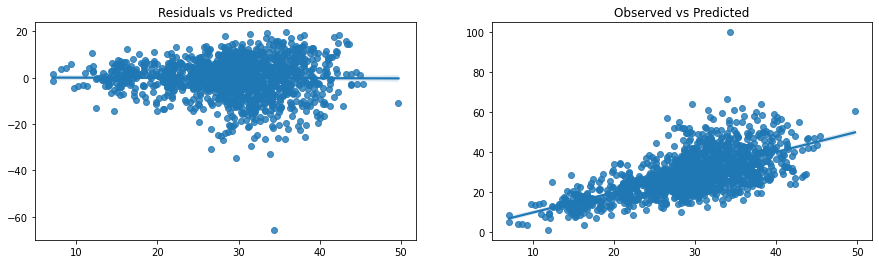

In [154]:
#import package
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

#create highest performing model
mdl = RandomForestRegressor(max_depth=146, min_samples_leaf=9, min_samples_split=8, n_estimators=1237)
mdl.fit(sc_X_train, sc_y_train)

#predict data
sc_y_pred = mdl.predict(sc_X_test)
residuals = sc_y_pred - sc_y_test

#set plot area
f, axes = plt.subplots(1, 2)
f.set_size_inches(15, 4)

#make homoscedasticity plot
sns.regplot(x = sc_y_pred, y = residuals, ax=axes[0])
axes[0].set_title('Residuals vs Predicted')

#make linearity plot
sns.regplot(x = sc_y_pred, y = sc_y_test, ax=axes[1])
axes[1].set_title('Observed vs Predicted')

#show plots
plt.show()

**Feature importance**

Now let's look at feature importance scores:

In [155]:
ranf_imp = pd.DataFrame(mdl.feature_importances_, index = mdl.feature_names_in_, columns = ['Importance']).sort_values(by = 'Importance', ascending= False)
ranf_imp.head()

,Importance
percBAME_2011,0.358464
prop0_15,0.123345
propVac,0.102180
IMD_score,0.078247
percOvercrowded_2011,0.064341


### 3.5 Highest performing model evaluation - Linear Model

**Modelling**

Let's assess the ElasticNet model trained on scaled data on the test dataset and look at the r2 score and assess our models predictions for heteroscedasticity and linearity:

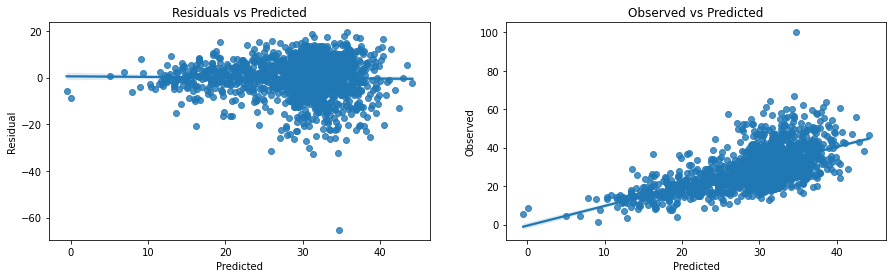

In [156]:
#import package
from sklearn.linear_model import ElasticNet
from sklearn import metrics

#create highest performing model
mdl = ElasticNet(alpha=1, warm_start=True)
mdl.fit(sc_X_train, sc_y_train)

#predict data
sc_y_pred = mdl.predict(sc_X_test)
residuals = sc_y_pred - sc_y_test

#set plot area
f, axes = plt.subplots(1, 2)
f.set_size_inches(15, 4)

#make homoscedasticity plot
ax1 = sns.regplot(x = sc_y_pred, y = residuals, ax=axes[0])
axes[0].set_title('Residuals vs Predicted')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residual')

#make linearity plot
ax2 = sns.regplot(y = sc_y_test, x = sc_y_pred, ax=axes[1])
axes[1].set_title('Observed vs Predicted')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Observed')

#show plots
plt.show()

**Feature importance**

Now let's look at model coefficient scores:

In [224]:
nlin_coef = pd.DataFrame(mdl.coef_, index = mdl.feature_names_in_, columns = ['Coef']).sort_values(by = 'Coef', ascending = False)
lin_coef = pd.DataFrame(abs(mdl.coef_), index = mdl.feature_names_in_, columns = ['Coef']).sort_values(by = 'Coef', ascending = False)#for comparison with ranf feature importance
nlin_coef.head*()

,Coef
prop0_15,0.387715
percBAME_2011,0.267353
propVac,0.224770
IMD_score,0.141311
percDeb_2011,0.052933
percOvercrowded_2011,0.036897
prop65+,0.029660
LifeExpFemale,0.029335
PopDens,0.020990
percAge15Smoking2014,0.020777


Let's look at coefficient scores for the ElasticNet model:

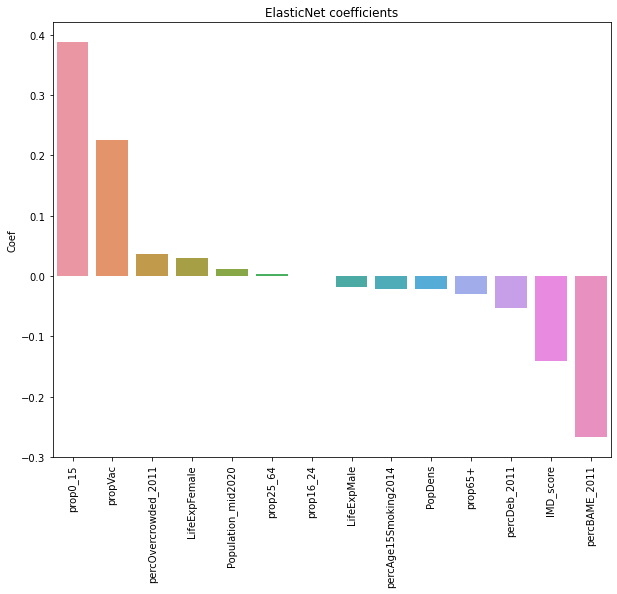

In [222]:
plt.figure(figsize = (10,8))
ax1 = sns.barplot(data = nlin_coef, y = 'Coef', x = nlin_coef.index)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
ax1.set_title('ElasticNet coefficients')
plt.show()

### 3.6 Visualising feature importance

Let's create a barchart to visualise the best linear and random forest models coefficient and feature importance scores:

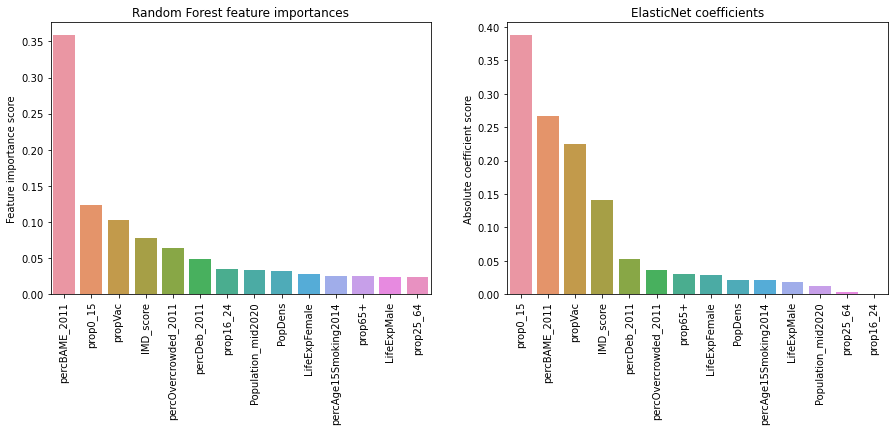

In [208]:
#craete subplots
fig, axes = plt.subplots(1,2, figsize=(15, 5))

#plot Random Forest chart
ax1 = sns.barplot(ax = axes[0], data = ranf_imp, y = 'Importance', x = ranf_imp.index)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
ax1.set_title('Random Forest feature importances')
ax1.set_ylabel('Feature importance score')

#plot ElasticNet chart
ax2 = sns.barplot(ax = axes[1], data = lin_coef, y = 'Coef', x = lin_coef.index)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)
ax2.set_title('ElasticNet coefficients')
ax2.set_ylabel('Absolute coefficient score')

#show plots
plt.show()

Independent variables rank similarly to one another across models. Let's asses the Spearman rank score between feature orders:

In [226]:
from scipy.stats import spearmanr
spearmanr(lin_coef.index, ranf_imp.index)

SpearmanrResult(correlation=0.5516483516483517, pvalue=0.040849058351122895)

Random Forest and ElasticNet model feature ranks produced a Spearman Rank score of 0.55, implying moderate correlation.

## 4. Modelling using discretized data

### 4.1 Discretize dependent variable using k-bins

Let's try training our models on discetized dependent variable. Let's use k-Means clustering to discretize the data:

In [245]:
#import packages
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import silhouette_score
import altair as alt

silhouette_avg = []
k_num = range(2,50)

for i in k_num:
    trans = KBinsDiscretizer(n_bins=i, encode='ordinal', strategy='quantile')
    labels = trans.fit_transform(sc_y.reshape(-1,1))
    silhouette_avg.append(silhouette_score(sc_y.reshape(-1,1), labels.ravel()))
    
#create df
silh_df = pd.DataFrame([k_num, silhouette_avg]).T
silh_df.columns = ['k_num', 'silhouette_score']

#plot df
alt.Chart(silh_df).mark_line().encode(x = 'k_num', y = 'silhouette_score').properties(title='Clustering silhouette scores')

alt.Chart(...)

Silhouette scores intially decrease from 2 to 3 clusters, before beginning to increase beyond two clusters. Let's look at what range of results each cluster covers and the size of each cluster group:

In [246]:
from collections import Counter
import plotly_express as px

#prepare variables for chart
trans = KBinsDiscretizer(n_bins=43, encode='ordinal', strategy='quantile')
labels = trans.fit_transform(st_y.reshape(-1,1))

#reformat x label
y_lab = labels.tolist()
y_lab = np.array(y_lab).ravel()
y_lab = [int(x) for x in y_lab]

y = tr_y
z = np.unique(y_lab, return_counts=True)[1]

#create a list of sizes of length x
z_l = []
for lab in y_lab:
    z_l.append(z[lab])

#convert all values into array
y_lab_3d = np.array(y_lab)
z_3d = np.array(z_l)
y_3d = np.array(tr_y)

#create chart
fig = px.scatter(y = y_lab_3d, x = y_3d, color = z_3d, title="Clustered propCas coverage")
fig.update_xaxes(title_text='Standardized propCas')
fig.update_yaxes(title_text='Cluster number')
fig.update_layout(coloraxis_colorbar=dict(title="Cluster size (n)"))

We can see that our bins are of similar cluster size, but most of the clusters sit between `propCas` values of -1.5 and 1.5 due to the limited spread of the dependent variable.

### 4.2 Model using the discretized dependent variable

Let's see if we can build a high performing classifier using the discretized dependent variable. First let's create test-train sets from the discretized data:

In [247]:
#import package
from sklearn.model_selection import train_test_split

#create 1:5 test train split
st_X_train, st_X_test, lab_y_train, lab_y_test = train_test_split(st_X, y_lab, test_size=0.2, random_state=42)

Now let's build an optimized classifier using a Ridge regresssion to evalaute the predictive potential of discretized variables:

In [254]:
print("\nPerforming Ridge GridSearch...")
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer

#create scorerr
mcc_error = make_scorer(metrics.matthews_corrcoef)
scoring_met = 'accuracy'

#create 
rr = RidgeClassifier()
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
        
#create grid
param_grid = dict()
param_grid['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
param_grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
param_grid['fit_intercept'] = [True, False]
              
        
#run gridsearch
grid_search = GridSearchCV(estimator = rr, param_grid = param_grid, cv = cv, scoring = scoring_met, n_jobs = -1, verbose = 2)
grid_search.fit(st_X_train, lab_y_train)
        
#print score
print("accuracy score: ", grid_search.best_score_)


Performing Ridge GridSearch...
Fitting 10 folds for each of 64 candidates, totalling 640 fits
score:  0.057262214277976384


The optimized model has incredibly poor performance, producing an accuracy score of 0.057.

Now let's assesss Random Forest classifier:

In [628]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

#create scorerr
mcc_error = make_scorer(metrics.matthews_corrcoef)
scoring_met = 'accuracy'

#assign datasets
X_train = st_X_train
y_train = lab_y_train

#algorithm test datasets
#X_train = X_train.iloc[:200,:]
#y_train = lab_y_train[:200]
        
print("\nRunning Random Search...")
#specify variables
train_size = X_train.shape[0]
est_start = math.ceil(train_size)/100
n_estimators = [int(x) for x in np.linspace(start = math.ceil(train_size)/100, stop = math.ceil(train_size)/100*50, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(math.ceil(train_size)/100, math.ceil(train_size)/100*10, num = 10)]
max_depth.append(None)
min_samples_split = [2,4,6,8,10]
min_samples_leaf = [2,4,6,8,10]
bootstrap = [True, False]
        
        #create grid
random_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}
        
        #fit grid
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 40, cv = 3,scoring = scoring_met, verbose=1, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
best_model = rf_random.best_estimator_
        
#show scores
print("Random Search", scoring_met, "scores: ", rf_random.best_score_)


Running Random Search...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Random Search accuracy scores:  0.3868512761688596


In [ ]:
The Random Forest Classifier Produces

## 5. Dimensionality redution using PCA

Let's see if we can simplify our data using PCA dimensionality reduction:

In [235]:
#import package
from sklearn.decomposition import PCA

#instantiate PCA
pca = PCA(n_components=5)
pca.fit(st_X)
X_pca = pca.transform(st_X)

#print metrics
print("Original shape:   ", st_X.shape)
print("Transformed shape:", X_pca.shape)
print("Explained variance: ", pca.explained_variance_ratio_)
print("Sum explained variance: ", sum(pca.explained_variance_ratio_))

Original shape:    (6789, 14)
Transformed shape: (6789, 5)
Explained variance:  [0.38831975 0.20189653 0.10883773 0.06771288 0.06130772]
Sum explained variance:  0.828074611430492


We can see that reducing our data to 5 principal components captures 82% of the variance in the dataset. Let's train an optimized model on the PCA data and compare its performanace to models optimized on the whole dataset:

In [669]:
#import package
from sklearn.model_selection import train_test_split

#create 1:5 test train split
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(X_pca, tr_y, test_size=0.2, random_state=42)

First let's optimize a linear model on the PCA dataset:

In [670]:
[best_model, score] = Modeller(pca_X_train, pca_y_train, 'regression', 'neg_mean_absolute_error')
         
print("\nBest model paramters: ", best_model)
upp = float(max(pca_y_train))
low = float(min(pca_y_train))
ran = upp - low
prop_score = score/ran
print("\nProportional error (%): ", abs(prop_score)*100)

Regression selected...

Performing Ridge GridSearch...
Fitting 30 folds for each of 64 candidates, totalling 1920 fits
Optimized grid best training neg_mean_absolute_error score:  -0.6198862037011528

Performing Lasso GridSearch...
Fitting 30 folds for each of 32 candidates, totalling 960 fits
Optimized grid best training neg_mean_absolute_error score:  -0.6198207299767081

Performing ElasticNet GridSearch...
Fitting 30 folds for each of 32 candidates, totalling 960 fits
Optimized grid best training neg_mean_absolute_error score:  -0.6198386788934321

Optimized grid: Lasso 
Best training neg_mean_absolute_error :  -0.6198207299767081

Best model paramters:  Lasso(alpha=0.01, max_iter=10000, selection='random')

Proportional error (%):  7.911270856658927


Now,  let's optimize a Random Forest model on the PCA dataset:

In [671]:
[best_model, score] = Modeller(pca_X_train, pca_y_train, 'ensemble', 'neg_mean_absolute_error')
         
print("\nBest model paramters: ", best_model)
upp = float(max(pca_y_train))
low = float(min(pca_y_train))
ran = upp - low
prop_score = score/ran
print("\nProportional error (%): ", abs(prop_score)*100)

Ensemble selected...

Running Random Search...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Random Search neg_mean_absolute_error scores:  -0.6051051249892304

Running Optimized Search...
Fitting 3 folds for each of 324 candidates, totalling 972 fits

Optimized grid best training neg_mean_absolute_error score:  -0.6058453695566041

Best model paramters:  RandomForestRegressor(max_depth=54, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=1828)

Proportional error (%):  7.7328920831593235


Models trained using PCA data obtained similar training error scores to those trained on the complete dataset. This suggests that simplifying our dataset might not adversely affect model performance.

### 5.2 Forward feature selection

Let's use sequential feature selection to identify a high performing subset of features using the linear model:

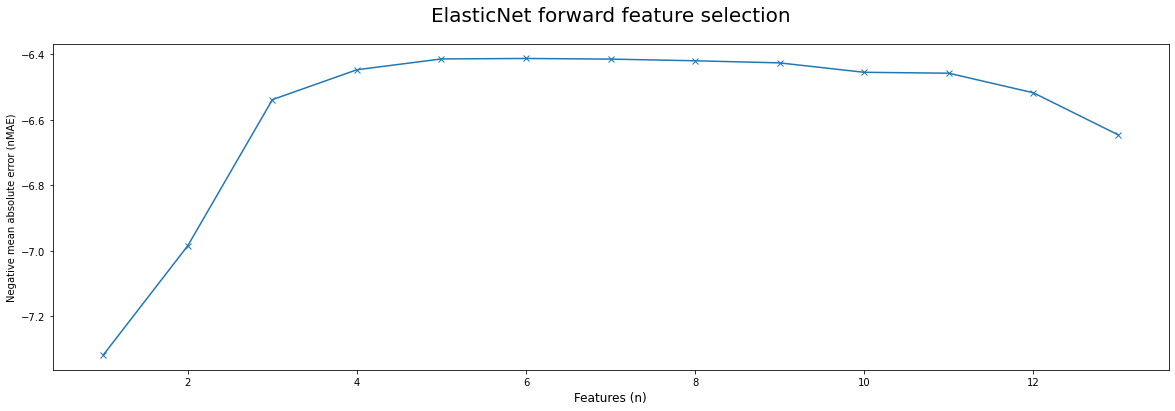

In [99]:
# import sequential feature selector
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import ElasticNet

#assign X, y
X = sc_X
y = sc_y

#assign classifiers
model = ElasticNet(alpha=1, warm_start=True)
#model = RandomForestRegressor(max_depth=108, max_features='sqrt', min_samples_leaf=2, min_samples_split=4, n_estimators=2986)

#assign variables
k  = np.arange(1,len(X.columns)).tolist()
score = 'neg_mean_absolute_error'
b_cv_score = []
b_selected_features = []

#start loop
for value in k:
    
#create the SequentialFeatureSelector object, and configure the parameters.
    bsfs = SequentialFeatureSelector(model, 
               k_features=value,
               forward=True, 
               floating=False,
               scoring=score,
               cv=5,
               n_jobs = -1,
               verbose = 0
               )

#fit the object to the training data and append scores
    bsfs = bsfs.fit(X, y)
    b_cv_score.append(bsfs.k_score_)
    b_selected_features.append(X.columns[[(bsfs.k_feature_idx_)]])


#plot figure
ax = pd.DataFrame(b_cv_score,k).plot.line(figsize = (20,6), marker = "x")
ax.set_xlabel('Features (n)', fontsize = 12)
ax.get_legend().remove()
plt.title('ElasticNet forward feature selection', fontsize = 20, y = 1.05, x = 0.5)
plt.ylabel('Negative mean absolute error (nMAE)')
plt.show()

We can see peformance plateaus after 5 features. Let's identify the top 5 peforming features:

In [ ]:
selected_features = []
for list in b_selected_features[:6]:
    for val in list:
        if val not in selected_features:
            print(val)
            selected_features.append(val)
        else:
            pass       

All of these features are in the top 6 ranked features identified for optimal Random Forest and ElasticNet models in the feature importance section.

### 5.3 Linear modelling and evaluation

Let's run the high performing subset through the Modeller function:

In [103]:
#import package
from sklearn.model_selection import train_test_split

#create X_mod
sc_X_sub = sc_X[b_selected_features[4].values]

#split dataset
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(sc_X_sub, sc_y, test_size=0.2, random_state=42)

In [115]:
[best_model, score] = Modeller(X_sub_train, y_sub_train, 'regression', 'neg_mean_absolute_error')

print("\nBest model paramters: ", best_model)
upp = float(max(y_sub_train))
low = float(min(y_sub_train))
ran = upp - low
prop_score = score/ran
print("\nProportional error (%): ", abs(prop_score)*100)

Regression selected...

Performing Ridge GridSearch...
Fitting 30 folds for each of 64 candidates, totalling 1920 fits
Optimized grid best training neg_mean_absolute_error score:  -6.260437791321537

Performing Lasso GridSearch...
Fitting 30 folds for each of 32 candidates, totalling 960 fits
Optimized grid best training neg_mean_absolute_error score:  -6.256189889307696

Performing ElasticNet GridSearch...
Fitting 30 folds for each of 320 candidates, totalling 9600 fits
Optimized grid best training neg_mean_absolute_error score:  -6.256189839712239

Optimized grid: ElasticNet 
Best training neg_mean_absolute_error :  -6.256189839712239

Best model paramters:  ElasticNet(alpha=1, l1_ratio=1.0, selection='random')

Proportional error (%):  7.72384471264672


We can see that reducing the dimensionalit of the dataset has minimal impact on the training error of models. Let's assess the optimal model on the test dataset:


Proportional error (%):  6.361805604037414 r2 0.38381271582022014


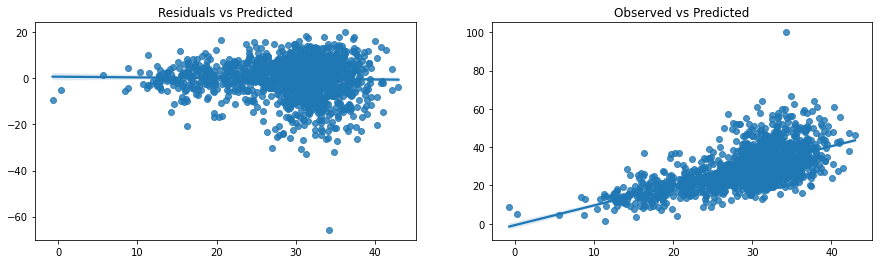

In [117]:
#import package
from sklearn import metrics

#predict data
y_pred = best_model.predict(X_sub_test)
y_test = y_sub_test
residuals = y_pred - y_test

#Calculate training performance scores

#produce accuracy score
score = -metrics.mean_absolute_error(y_test, y_pred)
upp = float(max(y_test))
low = float(min(y_test))
ran = upp - low
prop_score = score/ran

#show r2 score
r2 = metrics.r2_score(y_test, y_pred)

#show scores
print("\nProportional error (%): ", abs(prop_score)*100, "r2", r2)

#set plot area
f, axes = plt.subplots(1, 2)
f.set_size_inches(15, 4)

#make homoscedasticity plot
sns.regplot(x = y_pred, y = residuals, ax=axes[0])
axes[0].set_title('Residuals vs Predicted')

#make linearity plot
sns.regplot(x = y_pred, y = y_test, ax=axes[1])
axes[1].set_title('Observed vs Predicted')

#show plots
plt.show()

Reducing the dimensionality of the dataset had minimal implications for test error. However the r2 value did drop by ~0.06 suggesting that the model could explain less of the variance.

## 6. Clustering

Let's identify the optimal cluster number for the whole dataset:


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 23/23 [00:14<00:00,  1.60it/s]

[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


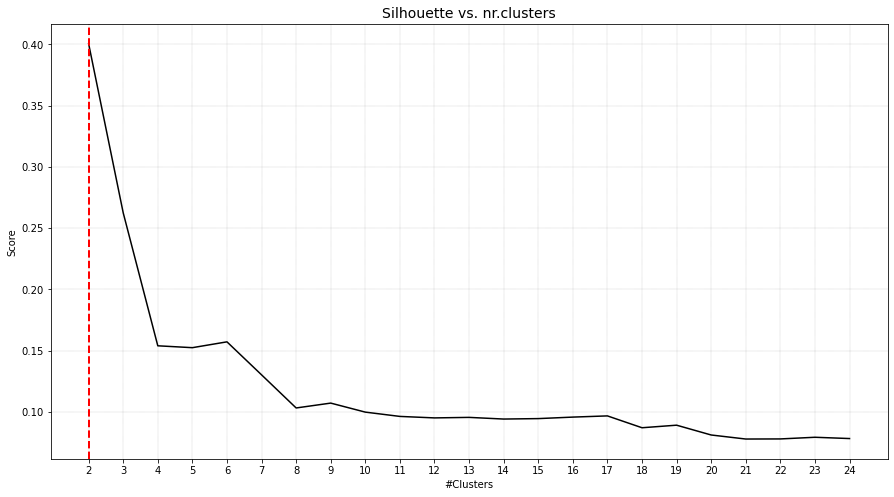

[clusteval] >Estimated number of n_clusters: 2, average silhouette_score=0.400


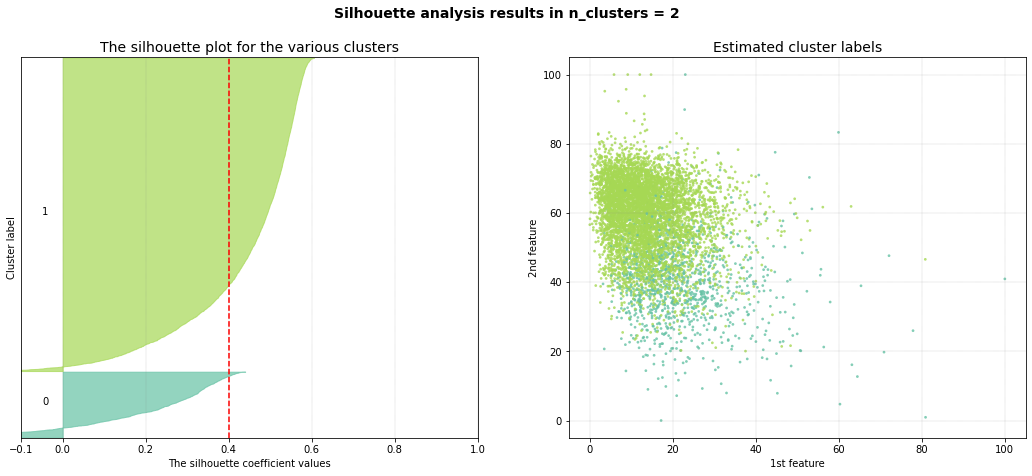

In [192]:
from clusteval import clusteval
ce1 = clusteval(evaluate='silhouette')

ce1.fit(sc_X.values)
ce1.plot()
ce1_labs = ce1.results["labx"]
ce1.scatter(sc_X.values)

Silhouette scoring against sequentially increasing cluster sizes show that the optimal cluster number to be 2 for clustering on the whole scaled dataset. Looking at the silhouette plot we can see that this creates one large cluster and a much smaller cluster. 

Let's asses optimal cluster number on the high perorming subset of data:


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 23/23 [00:14<00:00,  1.60it/s]

[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.


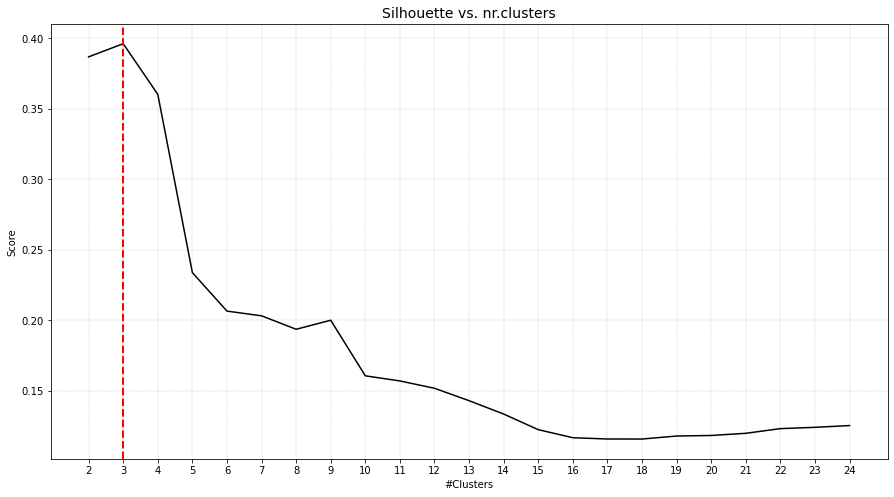

[clusteval] >Estimated number of n_clusters: 3, average silhouette_score=0.396


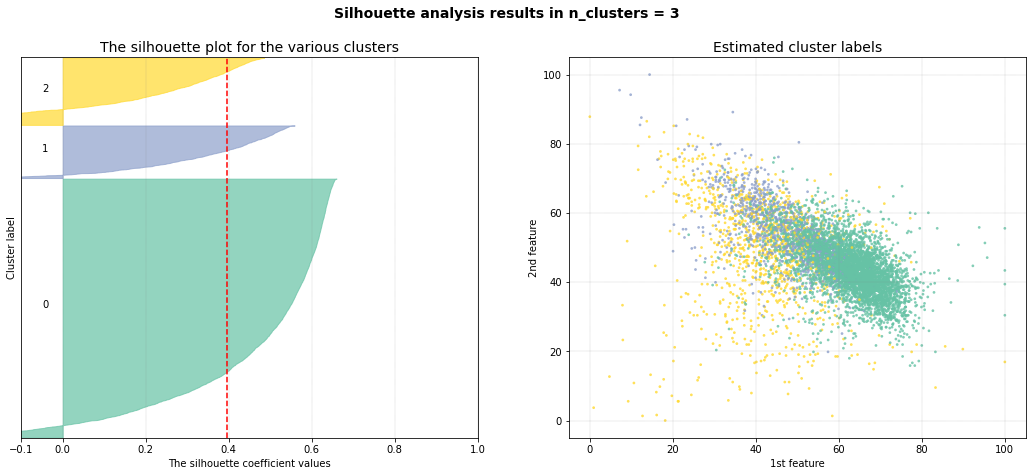

In [193]:
from clusteval import clusteval
ce2 = clusteval(evaluate='silhouette')

ce2.fit(sc_X_sub.values)
ce2.plot()
ce2_labs = ce2.results["labx"]
ce2.scatter(sc_X_sub.values)

Silhouette scoring against sequentially increasing cluster sizes show that the optimal cluster number to be 3 for clustering on the whole scaled dataset. Looking at the silhouette plot we can see that this creates one large cluster and two smaller clusters. Despite having producing marginally worse silhouette scores, having more clusters may be preferable for visual analysis as this provides more granularity to groupings.